In [1]:
import re
import glob
import nltk
import unidecode
import numpy as np
import unicodedata
import contractions
import pandas as pd
#from bs4 import BeautifulSoup
from collections import Counter
from nltk.corpus import stopwords
from googletrans import Translator
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, callbacks, preprocessing
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

import warnings
warnings.filterwarnings('ignore')

## 1. Data

In [2]:
jigsaw_tweets = pd.read_csv("jigsaw_toxic_data/train.csv")
jigsaw_tweets = jigsaw_tweets[["comment_text","toxic"]].rename(columns = {"comment_text":"text", "toxic":"target"})
print(jigsaw_tweets.shape)
jigsaw_tweets.head(2)

(159571, 2)


,text,target
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0


In [3]:
# The class is unbalanced :(
jigsaw_tweets.target.value_counts()

0    144277
1     15294
Name: target, dtype: int64

In [4]:
# The class is unbalanced :(
jigsaw_tweets.target.value_counts()

0    144277
1     15294
Name: target, dtype: int64

In [7]:
# Read more data
names = ["target", "id", "date", "flag", "user", "text"]
more_tweets = pd.read_csv("jigsaw_toxic_data/more_data/more_tweets.csv", names = names)

# Keep only toxic comments
more_tweets = more_tweets[more_tweets["target"] == 0].reset_index(drop = True)
more_tweets = more_tweets[["text", "target"]]

# Select only the amount of data required to "level" 
# both classes (toxic and non-toxic)
more_tweets = more_tweets[0:128983]

# Replace from 0 to 1
more_tweets["target"] = 1

# Append data to main dataframe
jigsaw_tweets = jigsaw_tweets.append(more_tweets).reset_index(drop = True)
print(jigsaw_tweets.shape)
jigsaw_tweets.head(2)

(288554, 2)


,text,target
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0


In [8]:
# Class is balanced! :D
jigsaw_tweets.target.value_counts()

0    144277
1    144277
Name: target, dtype: int64

## 2. Clean data
Before implementing the algorithm, we should start by cleaning and pre-processing our data, in this case, the papers csv is already loaded. The pre-processing phase includes the following steps and it's performed with help of the `PreProcessor` class:

- **Remove noise:** Noise removal is about removing characters digits and pieces of text that can interfere with text analysis. Noise removal is one of the most essential text preprocessing steps.


- **Normalize text:** Text normalization is the process of transforming a text into a canonical (standard) form. For example, the word “gooood” and “gud” can be transformed to “good”, its canonical form. 


- **Tokenization:** Tokenization is a way of separating a piece of text into smaller units called tokens. In this case tokens are words (but can also be characters or subwords).


- **Stemming:** Stemming is the process of reducing a word to its word stem that affixes to suffixes and prefixes or to the roots of words (known as a lemma).


- **Lemmatization:** Lemmatization is a method responsible for grouping different inflected forms of words into the root form, having the same meaning. It is similar to stemming.

In [9]:
class PreProcessor:
    
    def __init__(self, regex_dict = None):
        
        # creating classes
        # stem
        self.sb = nltk.stem.SnowballStemmer('english')
        
        # lemmatize
        self.lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
        
        # translate
        self.translator = Translator()
        
        # declare a default regex dict
        self.default_regex_dict = {'goo[o]*d':'good', '2morrow':'tomorrow', 'b4':'before', 'otw':'on the way',
                                   'idk':"i don't know", ':)':'smile', 'bc':'because', '2nite':'tonight',
                                   'yeah':'yes', 'yeshhhhhhhh':'yes', ' yeeeee':'yes', 'btw':'by the way', 
                                   'fyi':'for your information', 'gr8':'great', 'asap':'as soon as possible', 
                                   'yummmmmy':'yummy', 'gf':'girlfriend', 'thx':'thanks','nowwwwwww':'now', 
                                   ' ppl ':' people ', 'yeiii':'yes'}
        
        # if no regex_dict defined by user, then use 
        # one by default. Else, concat two regex dicts
        if regex_dict:            
            self.regex_dict = {**regex_dict, **default_regex_dict}
            
        else:
            self.regex_dict = self.default_regex_dict
    
    def removeNoise(self, pdf):
        
        """
        Function to remove noise from strings. 
        
        Inputs: A pandas dataframe with raw strings of length n.
        
        Output: A clean string where elements such as accented 
        words, html tags, punctuation marks, and extra white 
        spaces will be removed (or transform) if it's the case.
        """
        
        # to lower case
        pdf["clean_tweet"] = pdf.text.apply(lambda x: x.lower())
        
        # remove accented characters from string
        # e.g. canción --> cancion
        pdf["clean_tweet"] = pdf.clean_tweet.apply(lambda x: unidecode.unidecode(x))
        
        # remove html tags 
        pdf["clean_tweet"] = pdf.clean_tweet.str.replace(r'<[^<>]*>', '', regex=True)
        
        # remove (match with) usernames | hashtags | punct marks | links
        # punct marks = ",.':!?;
        # do not remove: ' 
        # but remove: "
        pdf["clean_tweet"] = pdf.clean_tweet.apply(lambda x:' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|([-.,:_;])|(https?:\/\/.*[\r\n]*)",
                                                                            " ", x).split()).replace('"',''))
                
        # remove white spaces at the begining and at 
        # the end of a string
        pdf['clean_tweet'] = pdf.clean_tweet.apply(lambda x: x.lstrip(' '))
        pdf['clean_tweet'] = pdf.clean_tweet.apply(lambda x: x.rstrip(' '))
        
        # normalize string
        # normalize accented charcaters and other strange characters
        # NFKD if there are accented characters (????
        pdf["clean_tweet"] = pdf.clean_tweet.apply(lambda x: unicodedata.normalize('NFKC', x).encode('ASCII', 'ignore').decode("utf-8"))
        
        return pdf
    
    
    def textNormalization(self, pdf):
        
        """
        Function to normalize a string. 
        
        Inputs: A pandas dataframe with strings (of length n) that 
        will be normalized. 
        
        Outputs: A normalized string whitout noise, words in their
        (expected) correct form and with no stopwords.
        """
        
        # remove noise first
        pdf = self.removeNoise(pdf)

        # expand contractions
        # e.g. don't --> do not
        pdf['clean_tweet'] = pdf.clean_tweet.apply(lambda x: contractions.fix(x))
         
        # Normalize words
        pdf['clean_tweet'] = pdf.clean_tweet.replace(self.regex_dict)
                
        # get English stopwords    
        stop_words = stopwords.words('english')
        stopwords_dict = Counter(stop_words)
        
        # remove stopwords from string
        pdf["clean_tweet"] = pdf.clean_tweet.apply(lambda x: ' '.join([word for word in x.split()
                                                                       if word not in stopwords_dict]))
        return pdf
    
    def wordTokenize(self, pdf):
        """
        Function to tokenize a string into words. Tokenization is a way 
        of separating a piece of text into smaller units called tokens.
        In this case tokens are words (but can also be characters or 
        subwords).
        
        Inputs: A pandas dataframe with strings (of length n) that will be tokenized. 
        
        Outputs: A list of tokenized words.
        """
        # string normalized
        #normalized = self.textNormalization(string)
        pdf = self.textNormalization(pdf)
        
        # Use word_tokenize method to split the string
        # into individual words. By default it returns
        # a list.
        pdf["clean_tweet"] = pdf.clean_tweet.apply(lambda x: nltk.word_tokenize(x))        
        
        # Using isalpha() will help us to only keep
        # items from the alphabet (no punctuation
        # marks). 
        pdf["clean_tweet"] = pdf.clean_tweet.apply(lambda x: [word for word in x if word.isalpha()])
        
        # Keep only unique elements
        pdf["clean_tweet"] = pdf.clean_tweet.apply(lambda x: list(set(x)))

        # return list of tokenized words by row
        return pdf
    
    
    def phraseTokenize(self, pdf):
        
        """
        Function to tokenize a string into sentences. Tokenization is
        a way of separating a piece of text into smaller units called
        tokens. In this case tokens are phrases (but can also be words,
        characters or subwords).
        
        Inputs: A string (of length n) that will be tokenized. 
        
        Outputs: A list of tokenized sentences.
        """
        
        # pandas dataframe with strings normalized
        pdf = self.textNormalization(pdf)
        
        # Use sent_tokenize method to split the string
        # into sentences. By default it returns a list.
        pdf["clean_tweet"] = pdf.clean_tweet.apply(lambda x: nltk.sent_tokenize(x))   
        
        return pdf 
    
    
    def stemWords(self, pdf):
        
        """
        Function to stem strings. Stemming is the process of reducing
        a word to its word stem that affixes to suffixes and prefixes 
        or to the roots of words (known as a lemma).
        
        Inputs: A raw string of length n.
        
        Output: Roots of each word of a given string.
        """
        
        # pandas dataframe with strings normalized
        pdf = self.textNormalization(pdf)
        
        # tokenized string (into words)
        pdf = self.wordTokenize(data)
            
        # reduct words to its root    
        pdf["clean_tweet"] = pdf.clean_tweet.apply(lambda x: [self.sb.stem(word) for word in x])
        
        return pdf
    
    
    def lemmatizeWords(self, pdf):
        
        """
        Function to lemmatize strings. Lemmatization is a method 
        responsible for grouping different inflected forms of 
        words into the root form, having the same meaning. It is 
        similar to stemming.
        
        Inputs: A raw string of length n.
        
        Output: Roots of each word of a given string (with better
        performance than in stemming).
        """
        
        # pandas dataframe with strings normalized
        pdf = self.textNormalization(pdf)
        
        # list of tokenized words (from string)
        # Here it was decided to tokenize by words
        # rather than by sentences due to we thought
        # it would be easier to find the correct roots
        # of each word.
        pdf = self.wordTokenize(pdf)
        
        # lematize word from list of tokenized words
        #lematized = [self.lemmatizer.lemmatize(word) for word in tokenized]
        pdf["clean_tweet"] = pdf.clean_tweet.apply(lambda x: [self.lemmatizer.lemmatize(word) for word in x])
        
        return pdf

In [10]:
# Create class object
pre_processor = PreProcessor()

# Clean data and only keep the roots of each word
jigsaw_tweets = pre_processor.lemmatizeWords(jigsaw_tweets)
jigsaw_tweets.head(2)

,text,target,clean_tweet
0,Explanation\nWhy the edits made under my usern...,0,"[edits, remove, voted, closure, since, york, r..."
1,D'aww! He matches this background colour I'm s...,0,"[seemingly, january, utc, thanks, colour, talk..."


In [11]:
jigsaw_tweets.tail(2)

,text,target,clean_tweet
288552,I can't stand foolish people or things!!!! W...,1,"[people, thing, foolish, food, thought, twitte..."
288553,@tcordrey My mum keeps bees but nearly all her...,1,"[keep, winter, hive, depth, country, due, mum,..."


## 3. Modeling
### 3.1 Prepare data

In [ ]:
measurer = np.vectorize(len)
measurer(jigsaw_tweets.clean_tweet).max(axis = 0)

In [12]:
# The maximum number of words to be used (most frequent).
n_words = 500000 # 500,000

# Max number of words in each tweet.
# Actually, the largest tweet has 392 words.
title_words = 392

# This is fixed.
emb_dim = 10

The [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf. Parameters used:
- `num_words`: Maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.
- `filters`: A string where each element is a character that will be filtered from the texts. The default is all punctuation, plus tabs and line breaks, minus the ' character.
- `lower`: Boolean. Whether to convert the texts to lowercase. 

Althought we have already filtered and converted the text into lower case, we decided to make sure everything works right by also implementing this function.

In [13]:
# Create class object.
tokenizer = preprocessing.text.Tokenizer(num_words = n_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', 
                                               lower = True)

# Updates internal vocabulary based on a list of texts.
# In our case, since texts contains lists, it is assumed each entry of the lists to be a token.
tokenizer.fit_on_texts(jigsaw_tweets['clean_tweet'].values)

# Get dictionary of word indexes.
word_index = tokenizer.word_index

In [14]:
print('Found %s unique tokens.' % len(word_index))

Found 173519 unique tokens.


The `texts_to_sequences` method transforms each text in texts to a sequence of integers, these integers are the IDs of each word from `word_index`. Only top num_words-1 (500,000 - 1) most frequent words will be taken into account, as well as words known by the tokenizer. On the other hand, with `pad_sequences` we can pads the generated sequences to the same length.

In [15]:
# Truncate and pad the input sequences so that they are all in the same length for modeling.
X = tokenizer.texts_to_sequences(jigsaw_tweets['clean_tweet'].values)
X = preprocessing.sequence.pad_sequences(X, maxlen = title_words)

# Get labels of each input.
#Y = jigsaw_tweets[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].values
Y = jigsaw_tweets.target.values
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (288554, 392)
Shape of label tensor: (288554,)


In [16]:
# Split data into training and test data sets.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.30, random_state = 42, stratify = Y)
print("Train sets:", X_train.shape, Y_train.shape)
print("Test sets:", X_test.shape, Y_test.shape)

Train sets: (201987, 392) (201987,)
Test sets: (86567, 392) (86567,)


### 3.2 Keras model

#### 3.2.1 Model methods.
- `Sequential`: Groups a linear stack of layers into a `tf.keras.Model`.
- `add`: Adds a layer instance on top of the layer stack.
- `compile`: Configures the model for training.
- `fit`: Trains the model for a fixed number of epochs (iterations on a dataset).

#### 3.2.2 Layers
- `Embedding`: Turns positive integers (indexes) into dense vectors of fixed size. This is our first layer and uses vectors of length 10 to represent each word. Parameters:
    - `input_dim`: Size of the vocabulary, i.e. maximum integer index + 1. 
    - `output_dim`: Dimension of the dense embedding. 
    - `input_length`: Length of input sequences (when it is constant).


- `SpatialDropout1D`: Performs variational dropout in NLP models. To get more context:
    - **dropout** is a regularization technique for neural networks that drops a unit (along with connections) at training time with a specified probability $p$ (usually $p = 0.5$). At test time, all units are present, but with weights scaled by $p$ (i.e. $w$ becomes $pw$). The idea is to prevent co-adaptation, where the neural network becomes too reliant on particular connections, as this could be symptomatic of overfitting. [3]
    - On the other hand, **variational dropout** is based on **dropout**, but uses a variational inference grounded approach. In Variational Dropout, the same dropout mask is repeated at each time step for both inputs, outputs, and recurrent layers (drop the same network units at each time step). This is in contrast to ordinary Dropout where different dropout masks are sampled at each time step for the inputs and outputs alone. [3]
    - Parameters: 
        - `rate`: Fraction of the input units to drop. 
    
    
- `LSTM`: Long Short-Term memory layer. It can process not only single data points (such as images), but also entire sequences of data (such as speech or video). Parameters:
    - `units`: Dimensionality of the output space. 
    - `dropout`: Fraction of the units to drop for the linear transformation of the inputs.
    - `recurrent_dropout`: Fraction of the units to drop for the linear transformation of the recurrent state.
    
    
- `Dense`: Regular densely-connected NN layer. The dense layer is a neural network layer that is connected deeply, which means each neuron in the dense layer receives input from all neurons of its previous layer. Actually, it is the most commonly used layer in the models. Parameters:
    - `units`: Dimensionality of the output space. 
    - `activation`: Activation function to use. Activation function is *softmax* for multi-class classification.
    
#### 3.2.3 Training
- `compile` method parameters:
    - `loss`: Because it is a binary classification problem, `BinaryCrossentropy` works.
    - `optimizer`: Name of optimizer.
    - `metrics`: List of metrics to be evaluated by the model during training and testing.
    
    
- `fit` method parameters:
    - `x`: Input data.
    - `y`: Target data.
    - `batch_size`: Number of samples per gradient update.
    - `epochs`: Number of epochs to train the model. 
    - `validation_split`: Fraction of the training data to be used as validation data.
    - `callbacks`: List of `keras.callbacks.Callback` instances.
        - `EarlyStopping`: Stop training when a monitored metric has stopped improving. Parameters:
            - `monitor`: Quantity to be monitored. 
            - `patience`: Number of epochs with no improvement after which training will be stopped. 
            - `min_delta`: Minimum change in the monitored quantity to qualify as an improvement.

In [17]:
# Create class object.
model = models.Sequential()

# Add layers.
model.add(layers.Embedding(n_words, emb_dim, input_length = X.shape[1]))
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(100, dropout = 0.2, recurrent_dropout = 0.2))
#model.add(layers.Dense(6, activation = 'softmax'))
model.add(layers.Dense(1, activation = 'sigmoid'))

# Prepare for training.
model.compile(loss = 'BinaryCrossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 392, 10)           5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 392, 10)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 5,044,501
Trainable params: 5,044,501
Non-trainable params: 0
_________________________________________________________________


In [19]:
epochs = 5
batch_size = 64 # 32

history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch_size, validation_split = 0.1,
                    callbacks = [callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, min_delta = 0.0001)])

Epoch 1/5
2841/2841 [==============================] - 2085s 733ms/step - loss: 0.2363 - accuracy: 0.9062 - val_loss: 0.1893 - val_accuracy: 0.9275
Epoch 2/5
2841/2841 [==============================] - 2322s 817ms/step - loss: 0.1881 - accuracy: 0.9282 - val_loss: 0.1928 - val_accuracy: 0.9261
Epoch 3/5
2841/2841 [==============================] - 2384s 839ms/step - loss: 0.1516 - accuracy: 0.9422 - val_loss: 0.1883 - val_accuracy: 0.9282
Epoch 4/5
2841/2841 [==============================] - 2382s 839ms/step - loss: 0.1392 - accuracy: 0.9473 - val_loss: 0.1945 - val_accuracy: 0.9263
Epoch 5/5
2841/2841 [==============================] - 2389s 841ms/step - loss: 0.1269 - accuracy: 0.9526 - val_loss: 0.1957 - val_accuracy: 0.9266


In [20]:
# Guardar el Modelo
model.save('trained_model/tf_keras_model.h5')

## 4. Evaluation Metrics

In [21]:
accr = model.evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

2706/2706 [==============================] - 185s 68ms/step - loss: 0.1899 - accuracy: 0.9284
Test set
  Loss: 0.190
  Accuracy: 0.928


In [22]:
import matplotlib.pyplot as plt

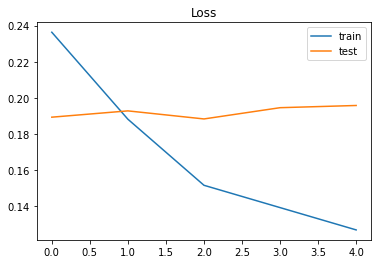

In [23]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

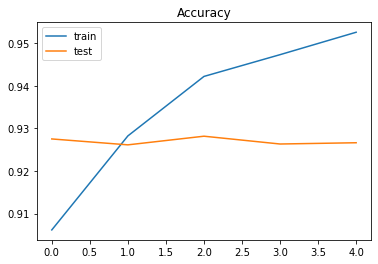

In [24]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

### 4.1 Sklearn metrics

In [25]:
# Predict
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)

In [26]:
def report(y_actual, y_predicted, conf_matrix):
    
    """
    This function will calculate all metrics previously explained.
    
    Args: This funtion receives the testing set of the variable to be predicted, the prediction of the target variable
    (made by an specific algorithm), and the confussion matrix (made by an specific algorithm).
    
    Returns: This function will print all metrics previously explained.
    """
    
    # Calculate false positives
    FP = conf_matrix.sum(axis = 0) - np.diag(conf_matrix) 
    
    # Calculate false negatives
    FN = conf_matrix.sum(axis = 1) - np.diag(conf_matrix)
    
    # calculate true positives
    TP = np.diag(conf_matrix)
    
    # calculate true negatives
    TN = conf_matrix.sum() - (FP + FN + TP)

    # error rate
    error_rate = ((FP + FN)/(TP + FP + FN + TN)).mean()
  
    # For accuracy, precision and recall, python already has predefined functions
    print("Accuracy = ", accuracy_score(y_actual, y_predicted))
    print("Precision = ", precision_score(y_actual, y_predicted, average = 'micro'))
    print("Recall = ", recall_score(y_actual, y_predicted, average = 'micro'))
    print('Error rate = ', error_rate)
    
    pass

In [27]:
# get confussion matrix
conf_matrix = confusion_matrix(y_pred, Y_test)

# get report :D
report(Y_test, y_pred, conf_matrix)

Accuracy =  0.9283560710201347
Precision =  0.9283560710201347
Recall =  0.9283560710201347
Error rate =  0.07164392897986531
